# Análise de Dados - Atrasos de Voos

Análise dos dados limpos.


### Configuração do ambiente
- **Objetivo:** preparar ambiente visual e importar bibliotecas
- **Saída:** dataframes prontos para análise.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import psycopg2

plt.style.use('seaborn-v0_8')
sns.set_theme(context="notebook", style="whitegrid")

### Estabelecer a conexão com um banco de dados

 - Base PostgreSQL local;
 - Executa a consulta SQL para extrair dados mensais de atrasos de voos a partir da tabela `silver.airline_delays`;
 - Carrega o resultado em um DataFrame do Pandas;
 - Encerra a conexão com o banco e, por fim, cria uma coluna de data no formato `datetime` combinando ano e mês (fixando o dia como 1º), preparando os dados para análises de séries temporais.


In [ ]:
conn = psycopg2.connect(
    host='localhost',
    port=5432,
    database='airline_delays',
    user='postgres',
    password='postgres'
)

query = """
SELECT year, month, carrier, carrier_name, airport, airport_name,
       arr_flights, arr_del15, carrier_ct, weather_ct, nas_ct,
       security_ct, late_aircraft_ct, arr_cancelled, arr_diverted,
       arr_delay, carrier_delay, weather_delay, nas_delay,
       security_delay, late_aircraft_delay
FROM silver.airline_delays
ORDER BY year, month
"""

df = pd.read_sql_query(query, conn)
conn.close()

df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

/tmp/ipykernel_25663/3798991639.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


---

## Gráfico 1: Matriz de Correlação


### Objetivo

Identificar a força e a direção do relacionamento linear entre as diferentes causas de atraso e métricas operacionais, evidenciando interdependências e possíveis efeitos sistêmicos no desempenho da malha aérea.

### Ações

* Seleção das principais causas de atraso a partir da tabela `silver.airline_delays`:

  * `carrier_delay` (atraso da companhia)
  * `weather_delay` (atraso meteorológico)
  * `nas_delay` (atraso do sistema nacional de aviação – NAS)
  * `late_aircraft_delay` (efeito cascata de aeronave atrasada)
* Inclusão de métricas operacionais associadas a falhas de serviço:

  * `arr_cancelled` (voos cancelados)
  * `arr_diverted` (voos desviados)

### Saída

Heatmap quadrado de correlação, com gradação de cores do azul (correlação fraca) ao vermelho (correlação forte), exibindo numericamente os coeficientes de correlação entre causas de atraso e métricas operacionais.


### Insight Esperado

Evidência de um **efeito cascata operacional**, no qual `late_aircraft_delay` apresenta forte correlação positiva com `carrier_delay` e `nas_delay`, indicando que atrasos iniciais tendem a se propagar ao longo da malha aérea. Além disso, espera-se observar que cancelamentos e desvios possuem correlações mais moderadas, sugerindo que atuam mais como respostas a falhas operacionais severas do que como causas diretas do atraso total.


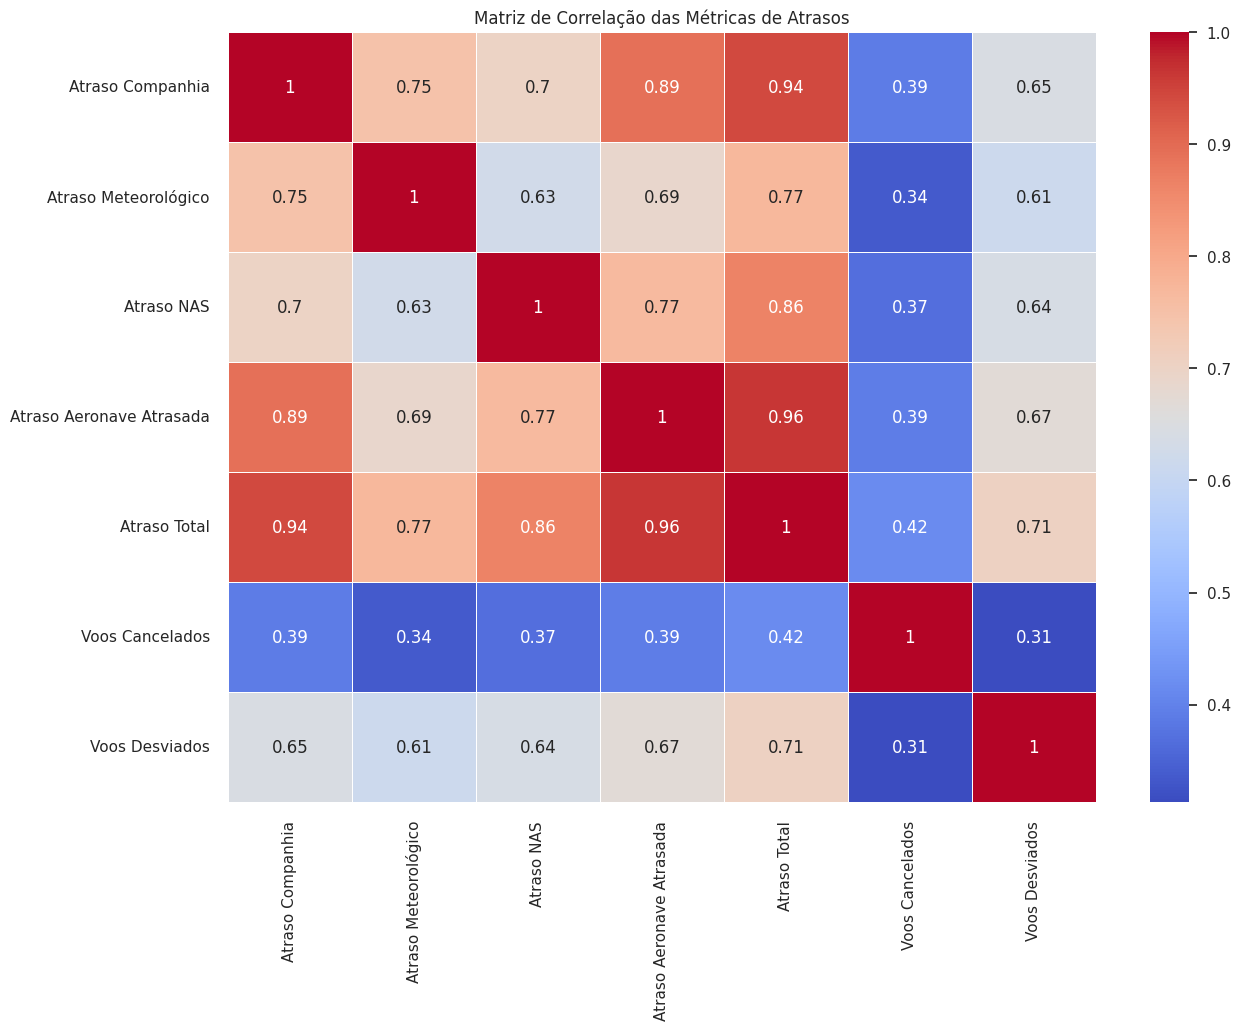

In [6]:
delay_reasons = ['carrier_delay', 'weather_delay', 'nas_delay', 'late_aircraft_delay']
df_corr = df[delay_reasons + ['arr_delay', 'arr_cancelled', 'arr_diverted']]

labels_pt = {
    'carrier_delay': 'Atraso Companhia',
    'weather_delay': 'Atraso Meteorológico',
    'nas_delay': 'Atraso NAS',
    'late_aircraft_delay': 'Atraso Aeronave Atrasada',
    'arr_delay': 'Atraso Total',
    'arr_cancelled': 'Voos Cancelados',
    'arr_diverted': 'Voos Desviados'
}

plt.figure(figsize=(14, 10))
corr_matrix = df_corr.corr()
corr_matrix = corr_matrix.rename(columns=labels_pt, index=labels_pt)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação das Métricas de Atrasos')
plt.show()

#### Insight Obtido

**O atraso total é fortemente explicado por atrasos operacionais (carrier + late aircraft + NAS), enquanto cancelamentos e desvios têm papel secundário e mais independente.**

Isso indica que **o problema principal não é cancelamento**, mas **ineficiência operacional acumulada**.




---

## Gráfico 2: Atraso Médio por Companhia Aérea

## Objetivo

Comparar a eficiência operacional das companhias aéreas, identificando as mais e menos pontuais.

### Ações

* Agrupar os dados da tabela `silver.airline_delays` por `carrier_name`
* Ordenar os resultados de forma decrescente pelo atraso médio

### Saída

Gráfico de barras horizontais com companhias no eixo Y e atraso médio (minutos) no eixo X.

### Insight Esperado

Identificação de companhias com problemas sistêmicos de pontualidade versus aquelas mais eficientes, permitindo avaliar o maior volume de operação implica pior desempenho.

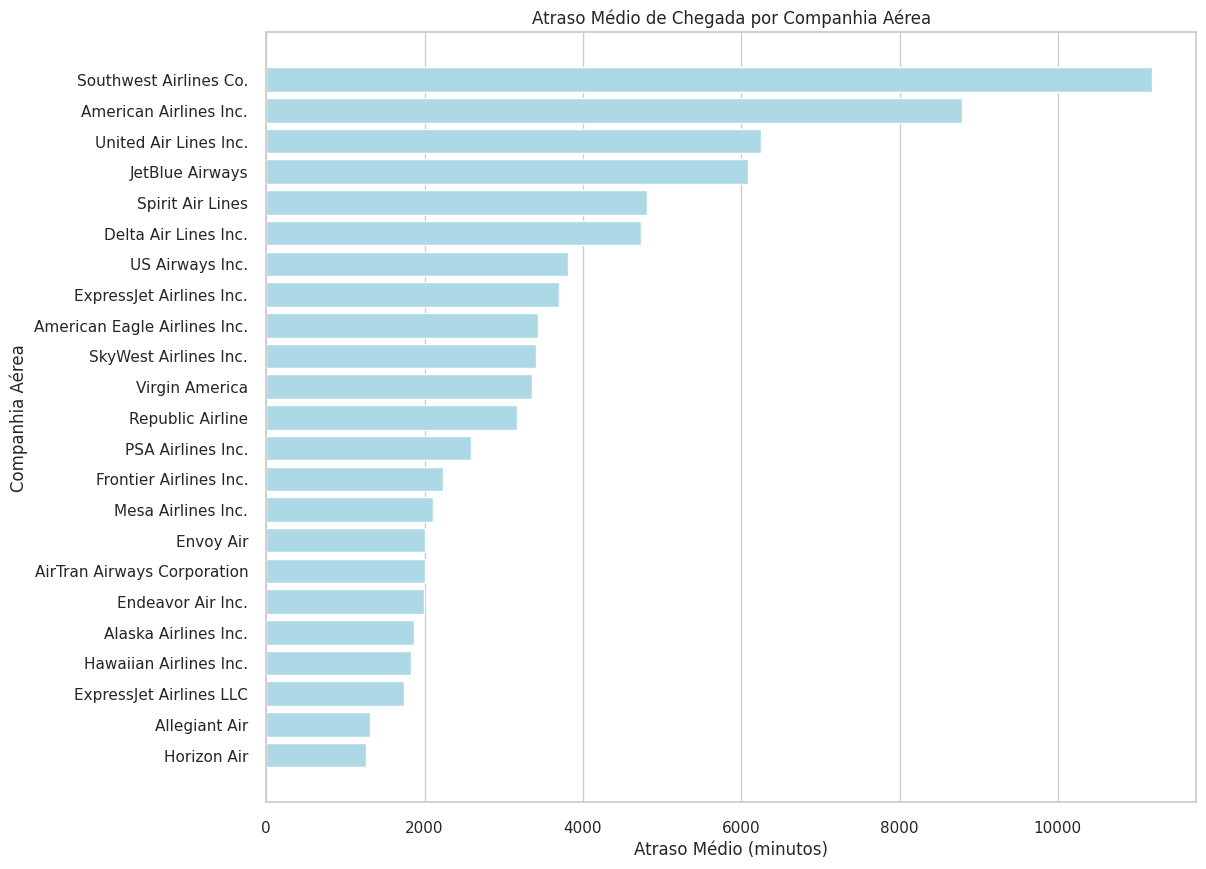

In [7]:
average_delay_per_carrier = df.groupby('carrier_name')['arr_delay'].mean().sort_values().reset_index()

plt.figure(figsize=(12, 10))
plt.barh(average_delay_per_carrier['carrier_name'], average_delay_per_carrier['arr_delay'], color='lightblue')
plt.title('Atraso Médio de Chegada por Companhia Aérea')
plt.xlabel('Atraso Médio (minutos)')
plt.ylabel('Companhia Aérea')
plt.grid(axis='y')
plt.show()

#### Insight Obtido

O gráfico revela uma heterogeneidade crítica no desempenho operacional das transportadoras, onde um pequeno grupo de empresas (liderado pela Southwest e American Airlines) concentra atrasos substancialmente superiores às demais. Isso indica que o volume de atrasos não é distribuído de forma uniforme pelo setor, sugerindo que fatores específicos de malha aérea.



---

## Gráfico 3: Impacto das Condições Meteorológicas

### Objetivo

Identificar padrões sazonais críticos de atrasos causados por clima ao longo do ano.

### Ações

* Agrupar os dados por `month` (1 a 12)
* Somar `weather_ct` para obter o volume absoluto de atrasos

### Saída

Gráfico de barras verticais com meses no eixo X e volume ou tempo médio de atraso no eixo Y.

### Insight Esperado

Visualização de picos sazonais, como atrasos no inverno (nevascas) e no verão (tempestades), apoiando ações de planejamento e contingência.

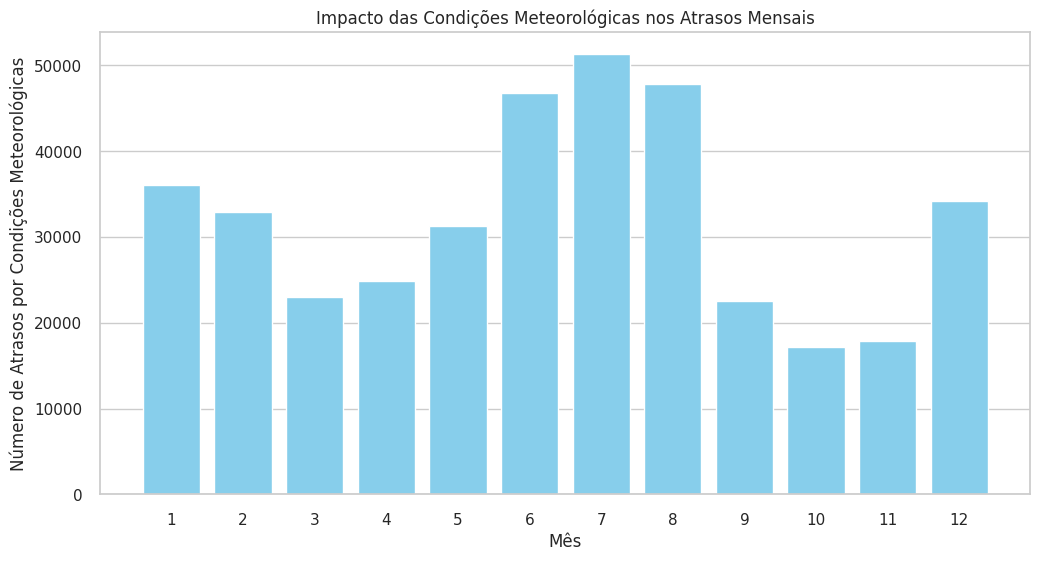

In [ ]:
weather_impact = df.groupby(['month'])['weather_ct'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(weather_impact['month'], weather_impact['weather_ct'], color='skyblue')
plt.title("Impacto das Condições Meteorológicas nos Atrasos Mensais")
plt.xlabel("Mês")
plt.ylabel("Número de Atrasos por Condições Meteorológicas")
plt.xticks(range(1, 13))
plt.grid(axis='x')

plt.show()

#### Insight Obtido

Os atrasos causados por condições meteorológicas apresentam um padrão sazonal bem definido, com pico acentuado entre junho e agosto, indicando que fatores climáticos típicos do meio do ano (tempestades, frentes frias ou eventos severos regionais) exercem impacto significativo e recorrente na operação aérea.




---

## Gráfico 4: Sazonalidade - Atrasos Mensais por Ano


### Objetivo
Identificar por mês o número de voos atrasados em pelo menos 15 minutos, segmentado por ano, permitindo observar o que pode influenciar nos atrasos, observando datas comemorativas ou efeitos globais gerais.

### Ações
- Agrupar os dados da tabela `silver.airline_delays` por `year` e `month`

### Saída
Gráfico de linhas múltiplas (*spaghetti plot*), com:
- Eixo X: meses (Jan–Dez)
- Eixo Y: taxa de atraso ou média de atraso

### Insight Esperado
- **Padrão estrutural**: Elevação consistente das curvas em junho/julho e dezembro confirma a sazonalidade associada a férias e clima  
- **Detecção de anomalias**: O ano de 2020 deve apresentar curva significativamente abaixo das demais, refletindo o impacto da pandemia  
- **Recuperação**: Comparar a forma da curva de 2023 com 2019 para avaliar o retorno ao comportamento pré-pandemia

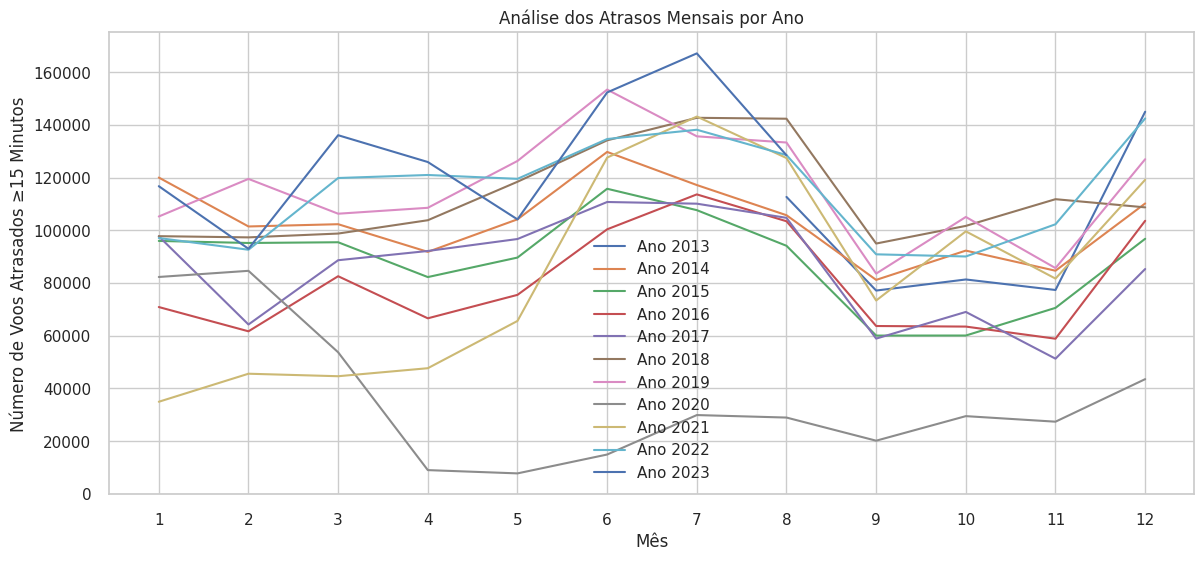

In [9]:
monthly_delays = df.groupby(['year', 'month'])['arr_del15'].sum().reset_index()

plt.figure(figsize=(14, 6))
for year in sorted(monthly_delays['year'].unique()):
    monthly_data = monthly_delays[monthly_delays['year'] == year]
    plt.plot(monthly_data['month'], monthly_data['arr_del15'], label=f'Ano {year}')

plt.title('Análise dos Atrasos Mensais por Ano')
plt.xlabel('Mês')
plt.ylabel('Número de Voos Atrasados ≥15 Minutos')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.show()

#### Insight Obtido

**Existe um padrão sazonal estrutural claro, com picos recorrentes de atrasos nos meses de junho/julho e dezembro, indicando que fatores como férias, aumento de demanda e condições climáticas impactam o sistema de forma consistente ao longo dos anos.**

O ano de 2020 se destaca como uma anomalia, apresentando níveis significativamente inferiores e uma curva “achatada”, reflexo direto da redução drástica do volume de voos durante a pandemia. Já 2023 apresenta uma forma de curva semelhante ao período pré-pandemia, sugerindo recuperação do padrão operacional, ainda que em patamares possivelmente mais voláteis.




---

## Gráfico 5: Tendência de Atrasos Totais ao Longo do Tempo


### Objetivo

Monitorar a evolução do impacto absoluto dos atrasos no sistema aéreo e nos passageiros.

### Ações

* Criar uma data mensal (YYYY-MM) a partir de `year` e `month`
* Somar `arr_delay` (minutos perdidos) ou `arr_del15` (voos atrasados)

### Saída

Gráfico de linha temporal com o tempo no eixo X e o total de atrasos no eixo Y.

### Insight Esperado

Diferenciar aumentos causados apenas pelo volume de voos de períodos de crise sistêmica com crescimento real do tempo perdido pelos passageiros.

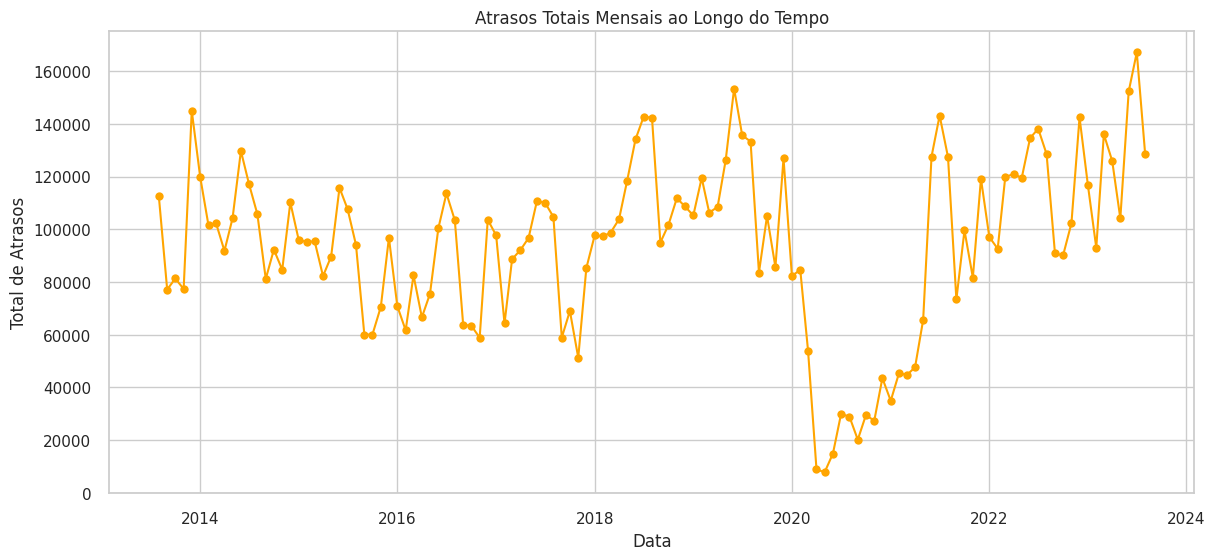

In [10]:
trend_data = df.groupby(['year', 'month'])['arr_del15'].sum().reset_index()
trend_data['date'] = pd.to_datetime(trend_data[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 6))
plt.plot(trend_data['date'], trend_data['arr_del15'], marker='o', color='orange')
plt.title('Atrasos Totais Mensais ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Total de Atrasos')
plt.grid(True)
plt.show()

#### Insight Obtido

gráfico revela que o setor aéreo passou de um regime de estabilidade sazonal previsível (2014-2019) para um estado de extrema volatilidade e degradação operacional no pós-pandemia. Embora a paralisação de 2020 tenha zerado temporariamente os problemas de pontualidade, a retomada não apenas retornou aos níveis antigos, mas estabeleceu novos recordes históricos de atrasos em 2023. Isso sugere que a infraestrutura e a logística atual do setor estão operando acima de sua capacidade de eficiência, tornando o sistema muito mais frágil a interrupções do que era há dez anos.

---

## Gráfico 6: Razões dos Atrasos (Grid 2x2)

### Objetivo

Identificar quais fatores estão impulsionando a ineficiência operacional ao longo do tempo.

### Ações

* Selecionar as principais causas de atraso:

  * `carrier_delay`
  * `weather_delay`
  * `nas_delay`
  * `late_aircraft_delay`
* Agrupar os dados por `year` e `month`

### Saída

Painel de *small multiples* (grid 2x2) com gráficos de linha, compartilhando os mesmos eixos de tempo e magnitude.

### Insight Esperado

Diferenciar responsabilidades operacionais e externas, identificando padrões como problemas de gestão de frota ou gargalos estruturais do sistema aéreo.

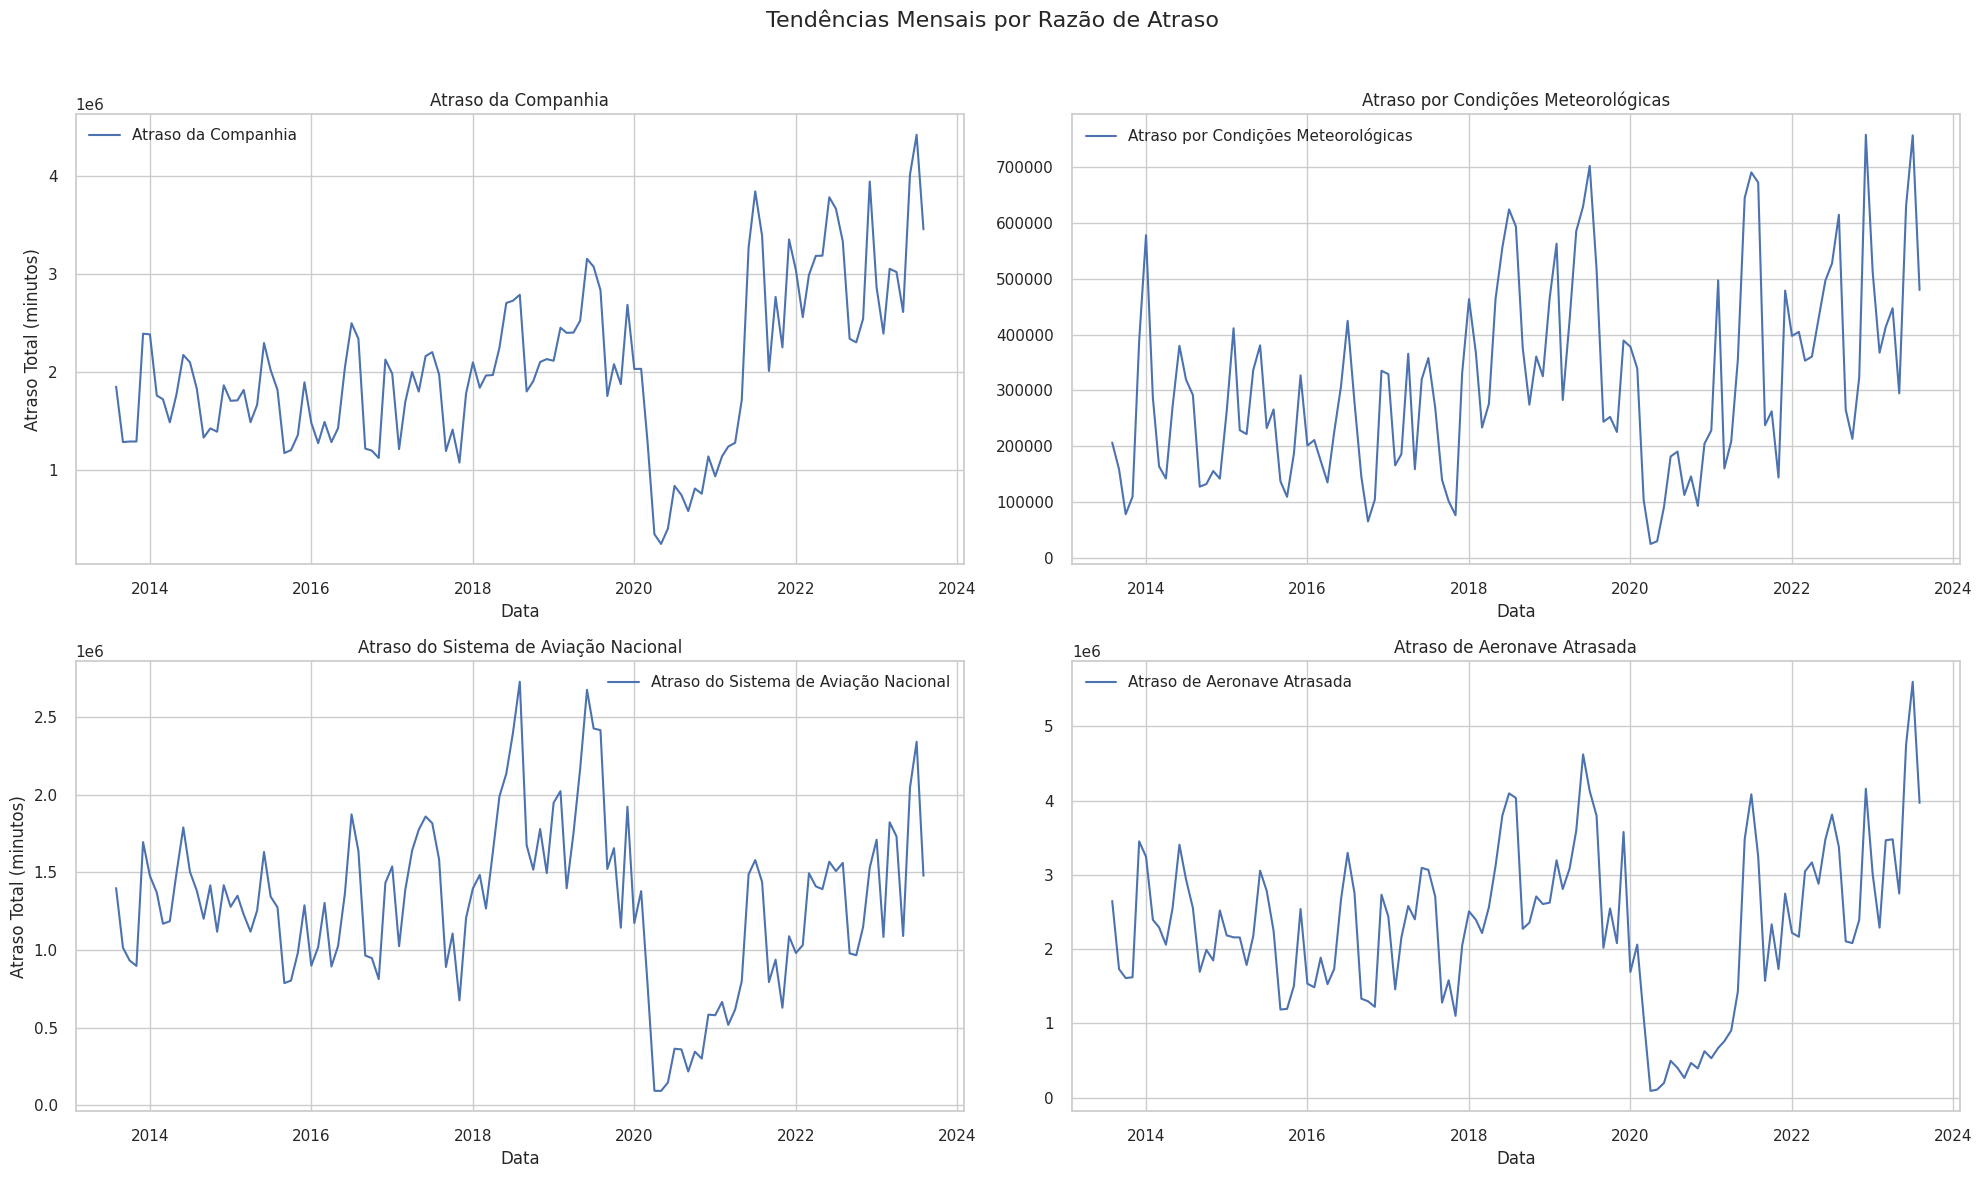

In [11]:
delay_reasons = ['carrier_delay', 'weather_delay', 'nas_delay', 'late_aircraft_delay']
titles_pt = ['Atraso da Companhia', 'Atraso por Condições Meteorológicas', 'Atraso do Sistema de Aviação Nacional', 'Atraso de Aeronave Atrasada']

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Tendências Mensais por Razão de Atraso', fontsize=16)

for i, (reason, title_pt) in enumerate(zip(delay_reasons[:4], titles_pt)):
    ax = axes[i // 2, i % 2]
    trend_data = df.groupby(['year', 'month'])[reason].sum().reset_index()
    trend_data['date'] = pd.to_datetime(trend_data[['year', 'month']].assign(day=1))
    ax.plot(trend_data['date'], trend_data[reason], label=title_pt)
    ax.set_title(title_pt)
    ax.set_xlabel('Data')
    if i % 2 == 0:
        ax.set_ylabel('Atraso Total (minutos)')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Insight Obtido

O cruzamento dos dados revela que o setor aéreo não apenas recuperou o volume de voos pós-2020, mas entrou em um ciclo de fadiga operacional. Enquanto o gráfico geral mostra recordes de ocorrências em 2023, o detalhamento por causas explica o porquê: o aumento é impulsionado principalmente por falhas internas (Atraso da Companhia) e pelo efeito cascata (Aeronave Atrasada), que atingiram picos de minutos perdidos muito superiores aos níveis de 2014-2019.

---


## Gráfico 7: Contribuição Média das Causas de Atrasos

### Objetivo

Determinar a representatividade percentual de cada causa no tempo total de atraso, identificando os principais gargalos sistêmicos.

### Ações

* Somar os tempos totais de atraso:
  `carrier_delay`, `weather_delay`, `nas_delay`, `security_delay`, `late_aircraft_delay`
* Calcular a participação percentual de cada causa em relação ao atraso total acumulado ((\sum \text{arr_delay}))
* Opcionalmente, calcular a média de minutos por voo atrasado para cada causa

### Saída

Gráfico de barras verticais.

### Insight Esperado

Revelar a dinâmica operacional real: causas logísticas, como `late_aircraft_delay` e `nas_delay`, tendem a representar a maior parcela do tempo perdido, superando fatores climáticos percebidos pelo público.

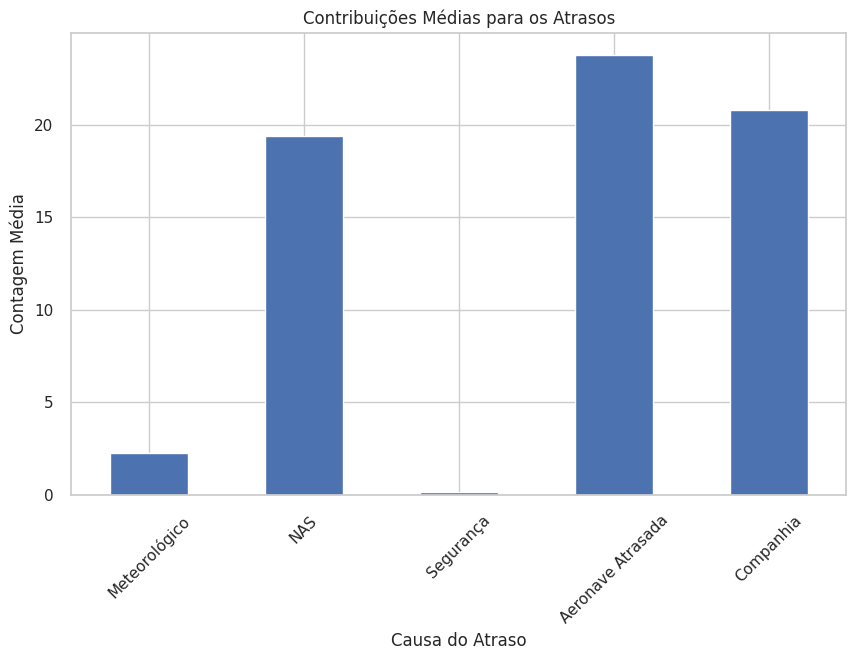

In [12]:
delay_factors = df[['weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'carrier_ct']].mean()

# Traduzir os nomes das causas de atraso
delay_factors_labels_pt = {
    'weather_ct': 'Meteorológico',
    'nas_ct': 'NAS',
    'security_ct': 'Segurança',
    'late_aircraft_ct': 'Aeronave Atrasada',
    'carrier_ct': 'Companhia'
}
delay_factors = delay_factors.rename(index=delay_factors_labels_pt)

plt.figure(figsize=(10, 6))
delay_factors.plot(kind='bar')
plt.title('Contribuições Médias para os Atrasos')
plt.xlabel('Causa do Atraso')
plt.ylabel('Contagem Média')
plt.xticks(rotation=45)
plt.show()

#### Insight Obtido

As diferentes causas de atraso possuem perfis estatísticos distintos: atrasos de companhia e NAS tendem a ser mais frequentes e menos extremos (problemas operacionais rotineiros), enquanto clima e segurança exibem caudas mais longas, caracterizando eventos menos frequentes, porém potencialmente catastróficos. Isso evidencia que frequência e severidade não caminham juntas e que estratégias de mitigação devem ser específicas por tipo de causa.

---


## Gráfico 8: Distribuição de Features Numéricas


### Objetivo
Caracterizar o comportamento estatístico dos atrasos, validando a hipótese de distribuição log-normal e identificando a severidade de eventos extremos (outliers).

### Ações
- **Filtragem crítica**:
  - Gerar visualizações considerando apenas `arr_delay > 0` ou `arr_delay > 15`

- **Comparação entre causas**:
  - Plotar histogramas *ridgeline plots* das principais causas:
    `carrier_delay`, `weather_delay`, `nas_delay`, `security_delay`, `late_aircraft_delay`

### Saída
Painel analítico contendo:
- Histogramas com curva de densidade (KDE)


### Insight Esperado
- **Frequência vs. severidade**: Identificar causas raras porém severas (ex: `security_delay`) versus causas frequentes com menor impacto individual  




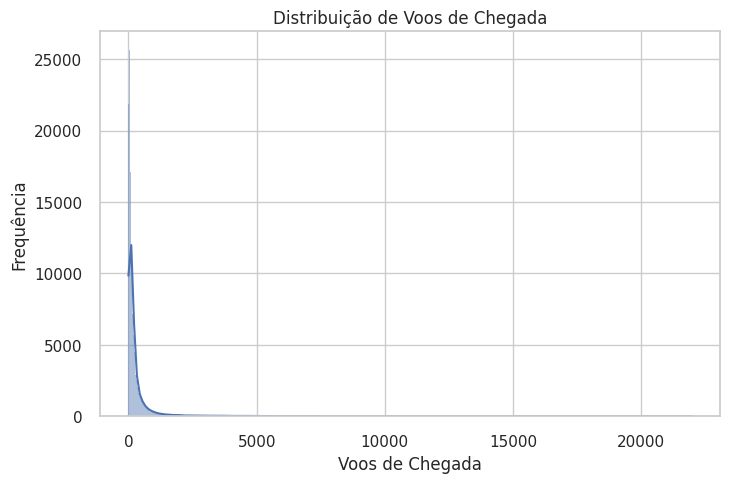

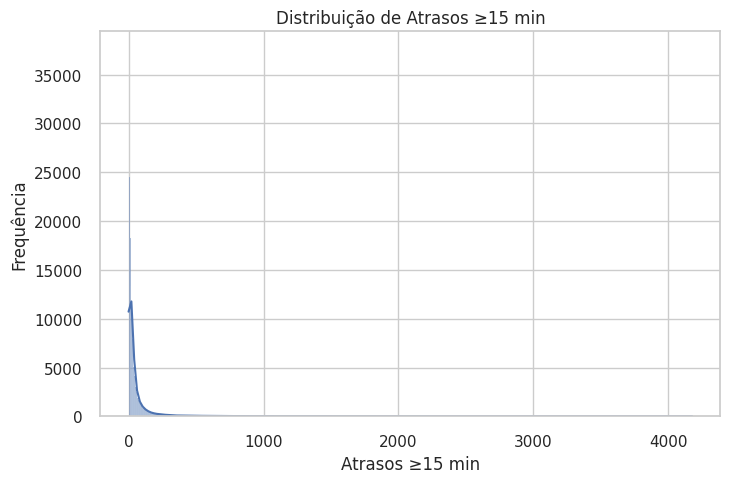

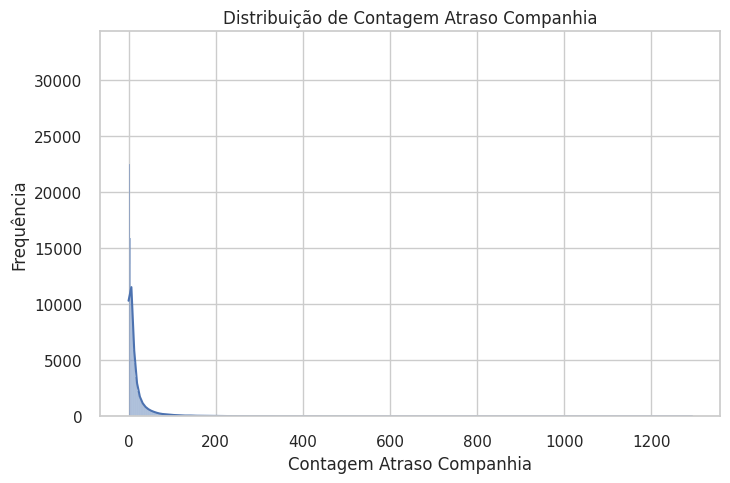

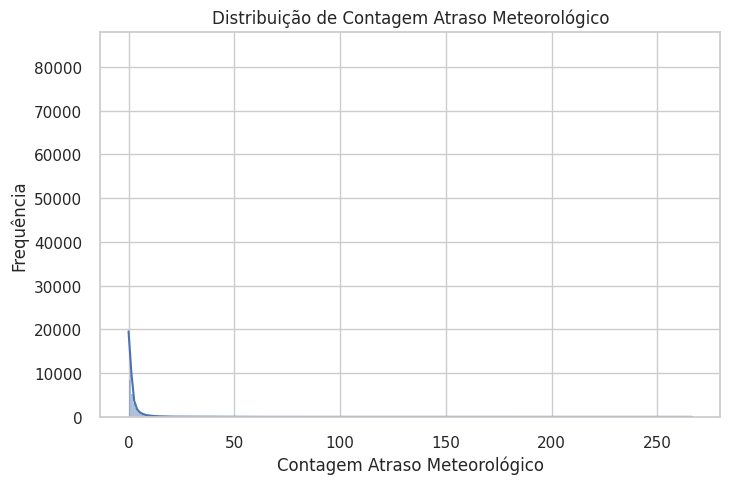

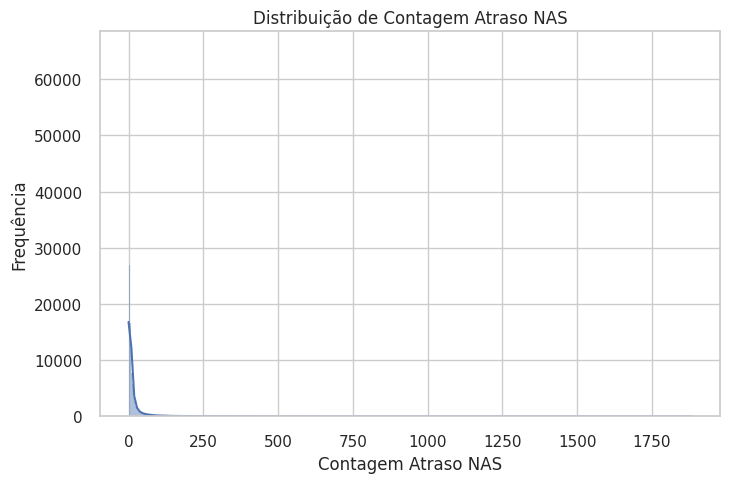

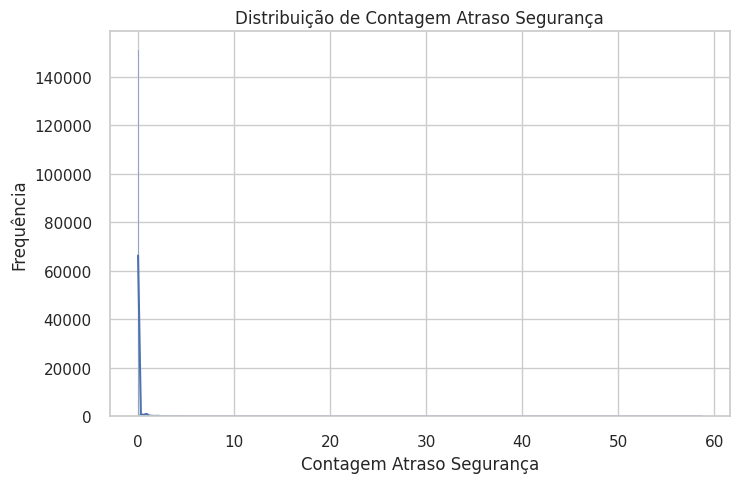

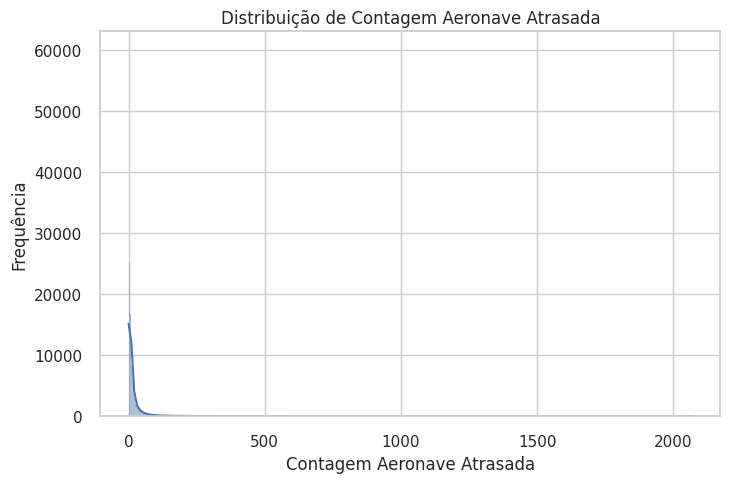

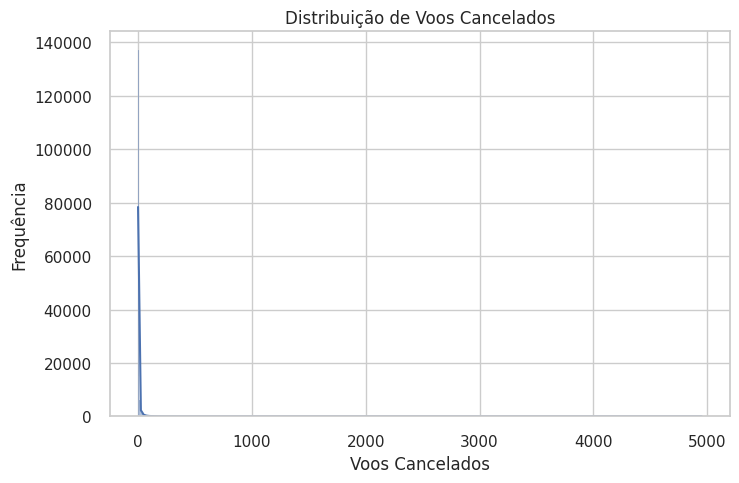

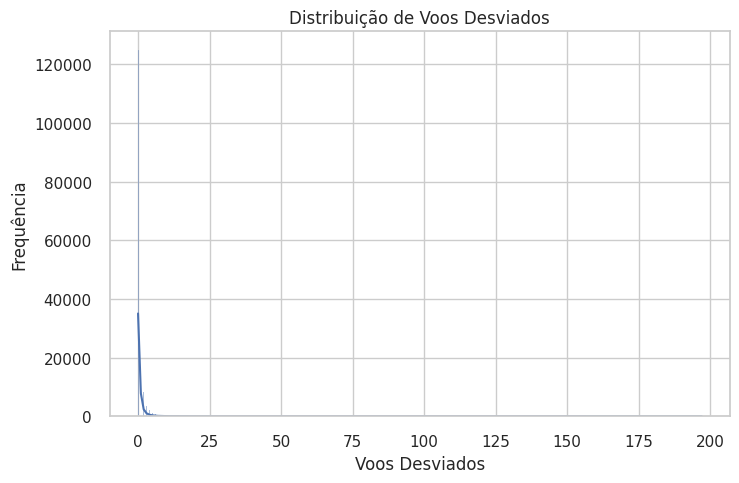

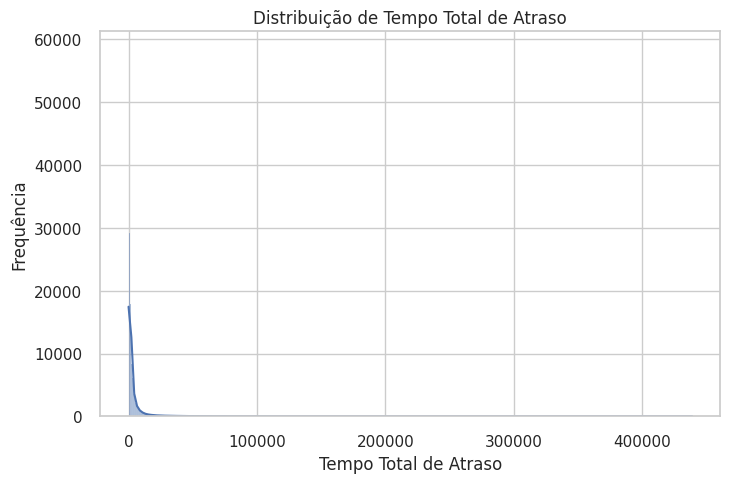

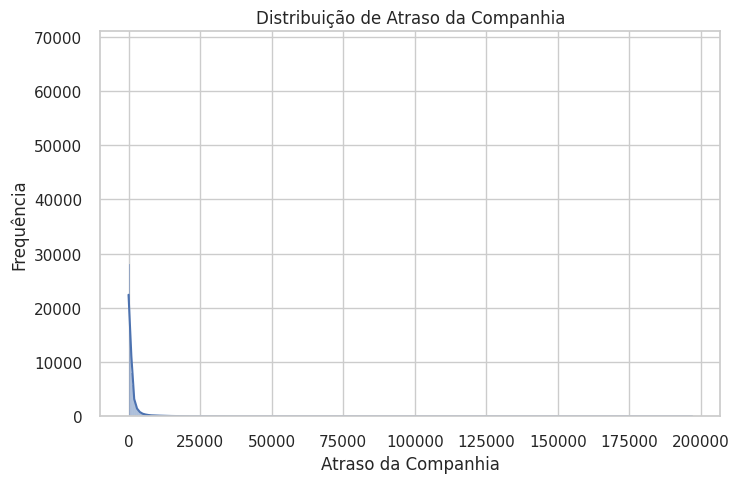

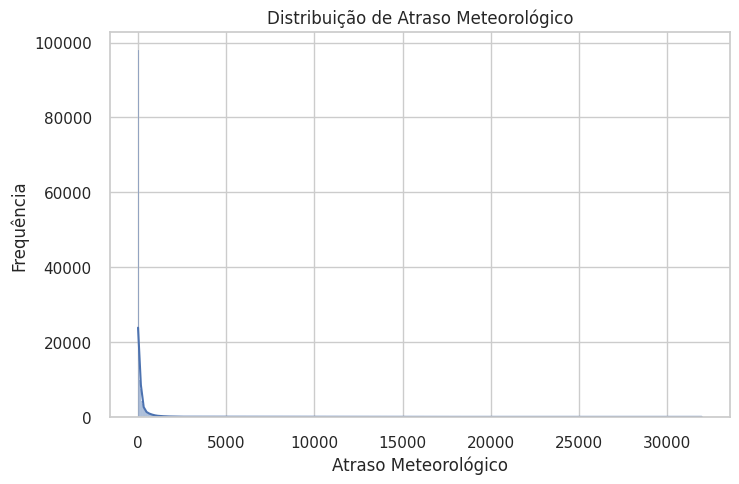

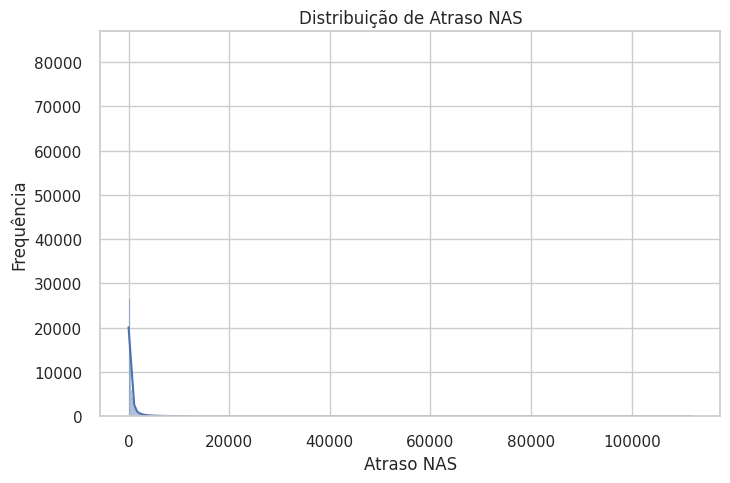

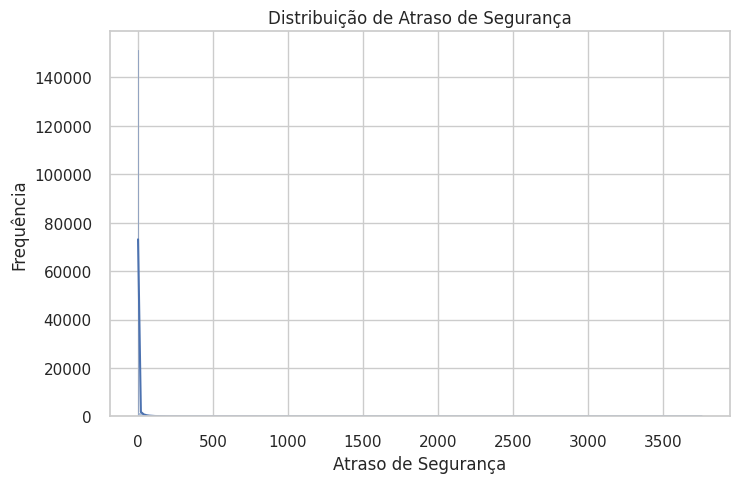

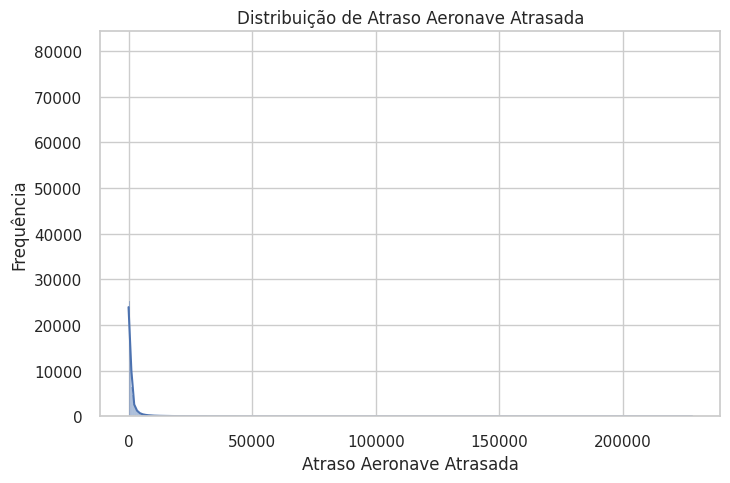

In [13]:
numeric_features = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
                    'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
                    'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
                    'security_delay', 'late_aircraft_delay']

feature_names_pt = {
    'arr_flights': 'Voos de Chegada',
    'arr_del15': 'Atrasos ≥15 min',
    'carrier_ct': 'Contagem Atraso Companhia',
    'weather_ct': 'Contagem Atraso Meteorológico',
    'nas_ct': 'Contagem Atraso NAS',
    'security_ct': 'Contagem Atraso Segurança',
    'late_aircraft_ct': 'Contagem Aeronave Atrasada',
    'arr_cancelled': 'Voos Cancelados',
    'arr_diverted': 'Voos Desviados',
    'arr_delay': 'Tempo Total de Atraso',
    'carrier_delay': 'Atraso da Companhia',
    'weather_delay': 'Atraso Meteorológico',
    'nas_delay': 'Atraso NAS',
    'security_delay': 'Atraso de Segurança',
    'late_aircraft_delay': 'Atraso Aeronave Atrasada'
}

for feature in numeric_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribuição de {feature_names_pt[feature]}')
    plt.xlabel(feature_names_pt[feature])
    plt.ylabel('Frequência')
    plt.show()

#### Insight Obtido

As distribuições de atraso apresentam assimetria positiva acentuada e cauda longa, compatíveis com uma distribuição Log-Normal, indicando que a maioria dos atrasos é pequena, mas poucos eventos extremos concentram grande parte do impacto operacional. Isso reforça que médias simples não representam bem a severidade real do problema, e que eventos raros, porém longos, são determinantes para o atraso total.

---


## Gráfico 9: Top Features Categóricas

### Objetivo

Identificar companhias aéreas e aeroportos que concentram o maior volume de operações e atrasos.

### Ações

* **Companhias**: agrupar por `carrier_name`, somar `arr_del15` e `arr_flights`, selecionar o Top 15
* **Aeroportos**: agrupar por `airport_name`, somar `arr_del15` e `arr_flights`, selecionar o Top 15

### Saída

Dois gráficos de barras horizontais:

* Top 15 Companhias com Mais Atrasos
* Top 15 Aeroportos com Mais Atrasos

### Insight Esperado

Confirmar a concentração dos atrasos em grandes hubs e distinguir alta exposição operacional de problemas crônicos de performance.

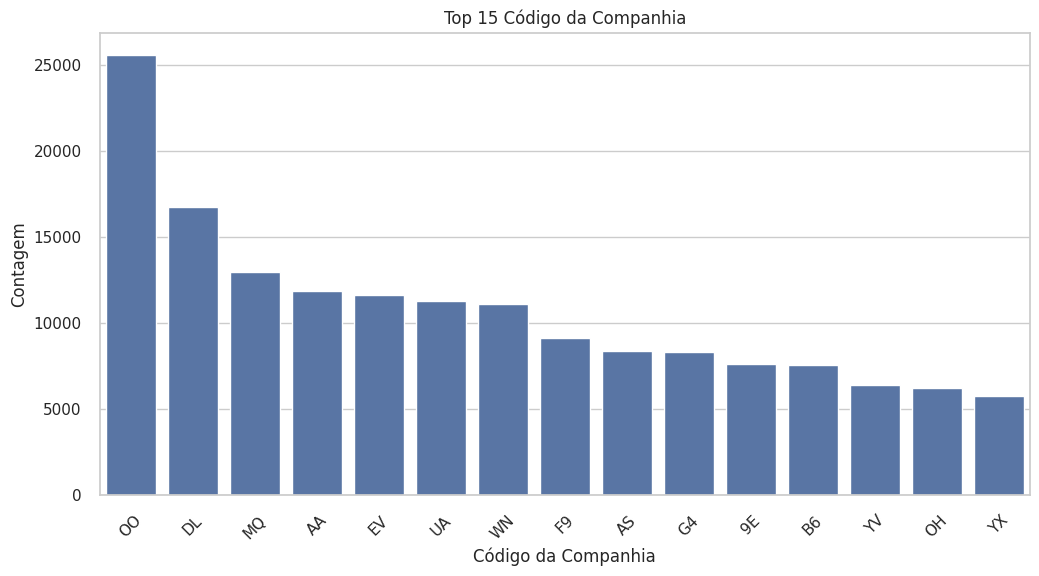

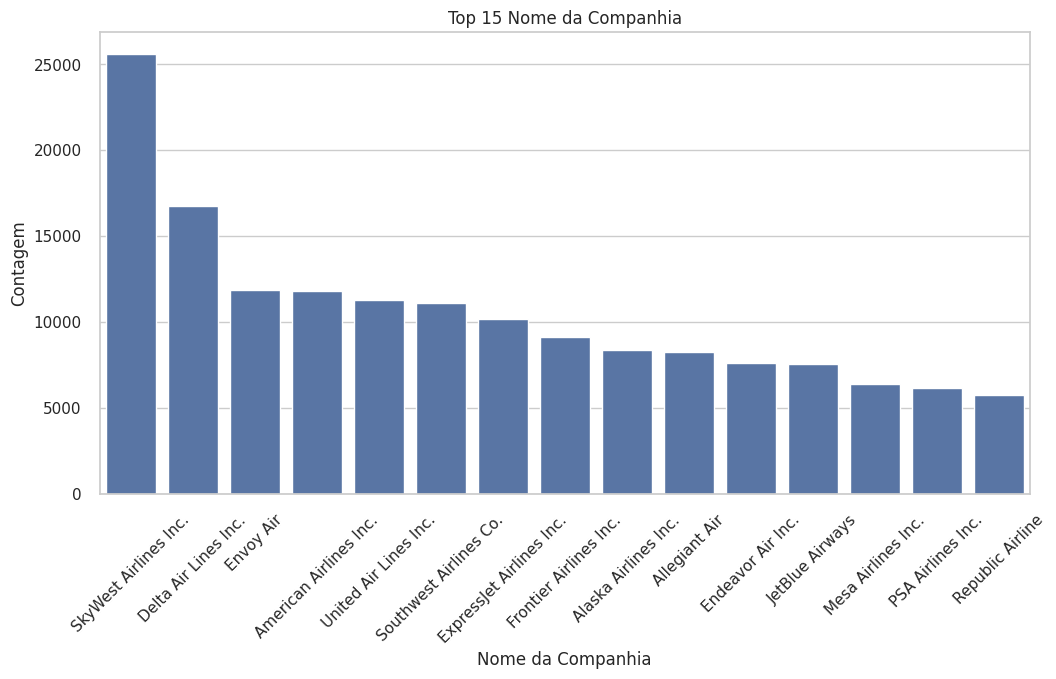

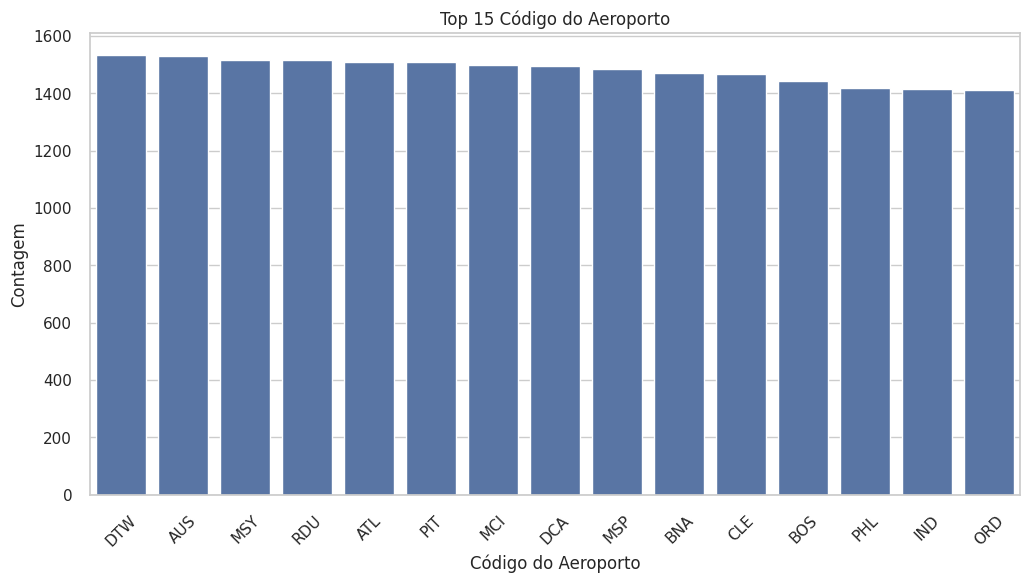

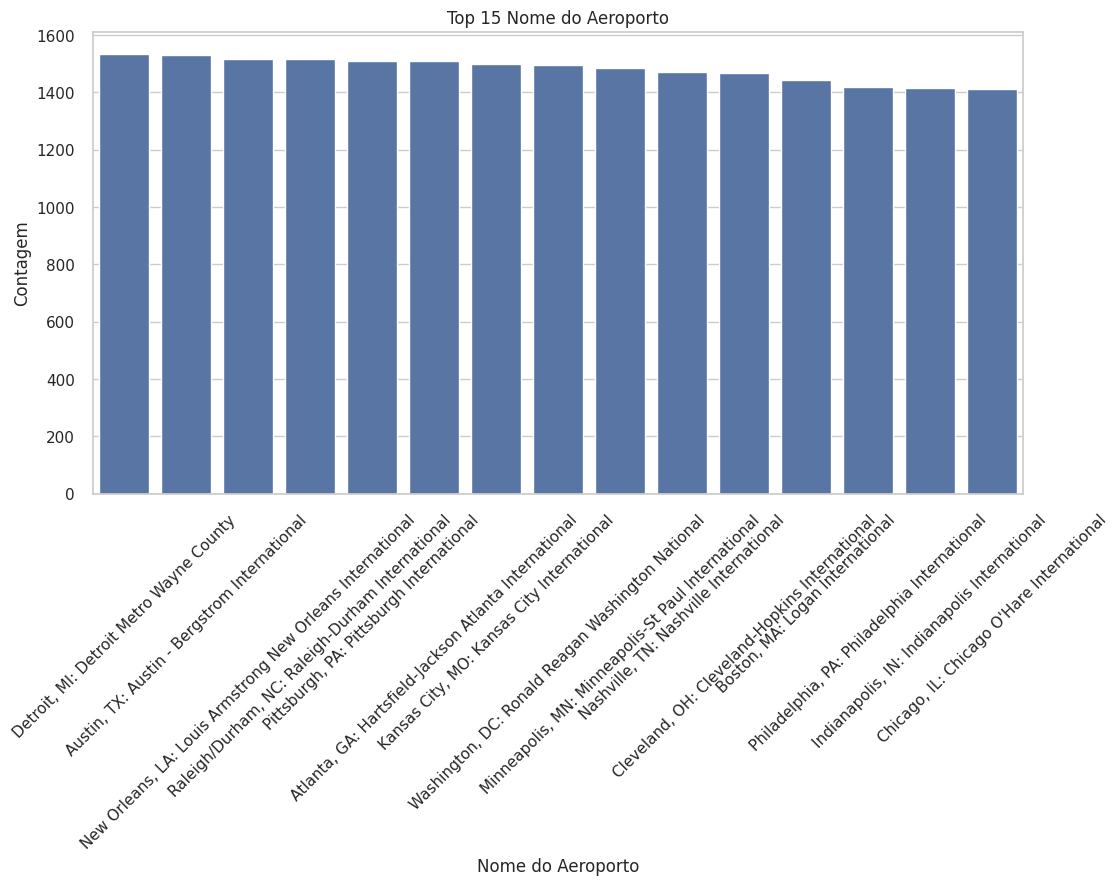

In [14]:
categorical_features = ['carrier', 'carrier_name', 'airport', 'airport_name']
categorical_names_pt = {
    'carrier': 'Código da Companhia',
    'carrier_name': 'Nome da Companhia',
    'airport': 'Código do Aeroporto',
    'airport_name': 'Nome do Aeroporto'
}

for feature in categorical_features:
    top_categories = df[feature].value_counts().nlargest(15)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_categories.index, y=top_categories.values)
    plt.title(f'Top 15 {categorical_names_pt[feature]}')
    plt.xlabel(categorical_names_pt[feature])
    plt.ylabel('Contagem')
    plt.xticks(rotation=45)
    plt.show()

#### Insight Obtido

Os dados indicam que o setor aéreo entrou em um estado de fadiga operacional recorde. Enquanto o período de 2014 a 2019 era caracterizado por uma estabilidade sazonal (atrasos mensais entre 60 mil e 140 mil), o cenário pós-2020 mostra uma escalada agressiva que culminou, no final de 2023, no maior volume de atrasos da década (superior a 160 mil ocorrências mensais).

---


## Gráfico 10: Tendência de Voos de Chegada ao Longo do Tempo

### Objetivo

Monitorar a evolução da demanda aérea e da capacidade operacional ao longo do tempo.

### Ações

* Agrupar os dados por `year` e `month`
* Somar `arr_flights` para cada período

### Saída

Gráfico de linha temporal com o volume total de voos no eixo Y.

### Insight Esperado

Visualizar choques sistêmicos e identificar padrões de recuperação e sazonalidade da demanda.

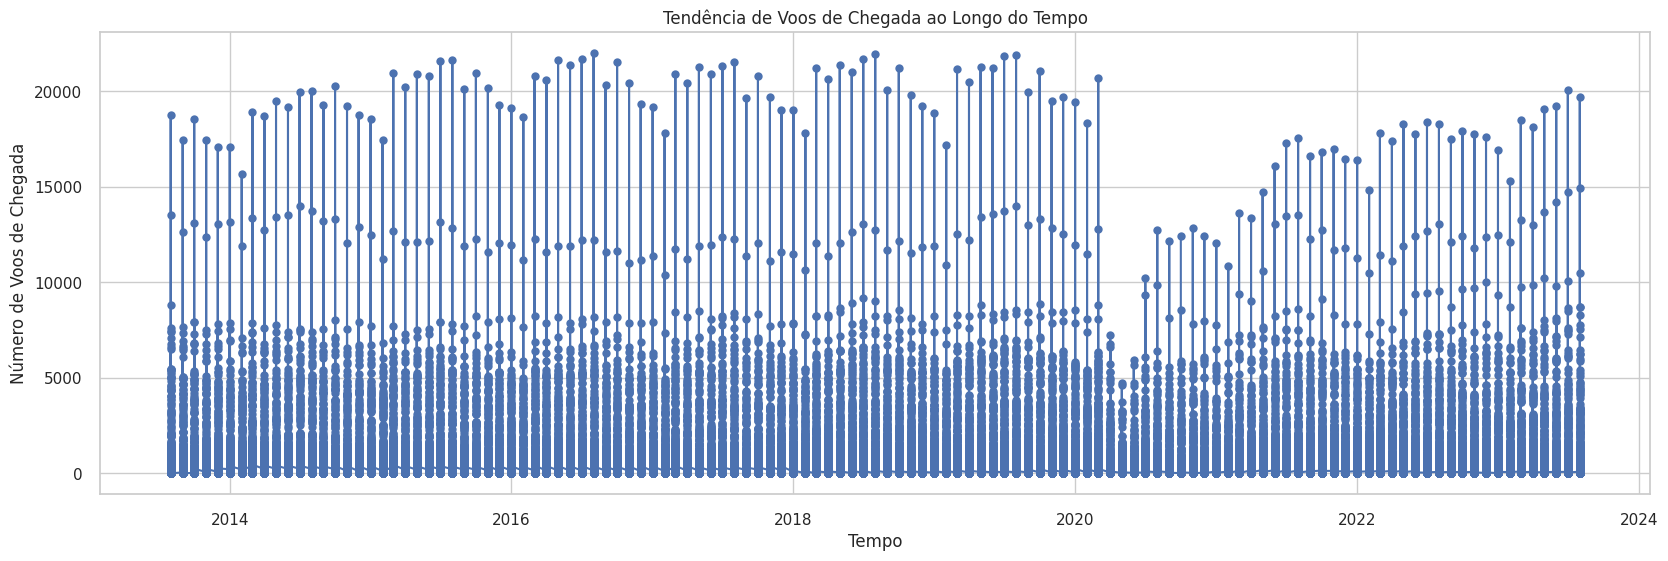

In [15]:
df_temp = df.copy()
df_temp = df_temp.set_index('date')
df_temp['arr_flights'] = df_temp['arr_flights']

plt.figure(figsize=(20, 6))
plt.plot(df_temp['arr_flights'], marker='o', linestyle='-')
plt.title('Tendência de Voos de Chegada ao Longo do Tempo')
plt.xlabel('Tempo')
plt.ylabel('Número de Voos de Chegada')
plt.show()

#### Insight Obtido

A análise dos dados revela o seguinte cenário: embora o número de voos de chegada ainda não tenha retornado consistentemente aos picos pré-pandemia de 22.000 voos, o volume total de atrasos mensais atingiu seu recorde histórico no final de 2023, superando 160.000 ocorrências. Isso indica que o sistema está operando com uma eficiência muito menor do que em 2019, sendo capaz de gerar mais atrasos mesmo com menos aeronaves no ar.

---


## Gráfico 11: Soma Mensal de Voos de Chegada

### Objetivo

Identificar padrões de evolução mensal do volume total de voos de chegada ao longo de aproximadamente uma década, permitindo identificar tendências de longo prazo, choques sistêmicos e padrões sazonais.

### Ações

* Agrupar os dados por `month`
* Somar `arr_flights` para cada mês

### Saída

Gráfico de linhas verticais representando o volume histórico total de voos por mês.

### Insight Esperado

Evidenciar picos de alta temporada e períodos de baixa demanda, facilitando análises de capacidade e correlação com atrasos.


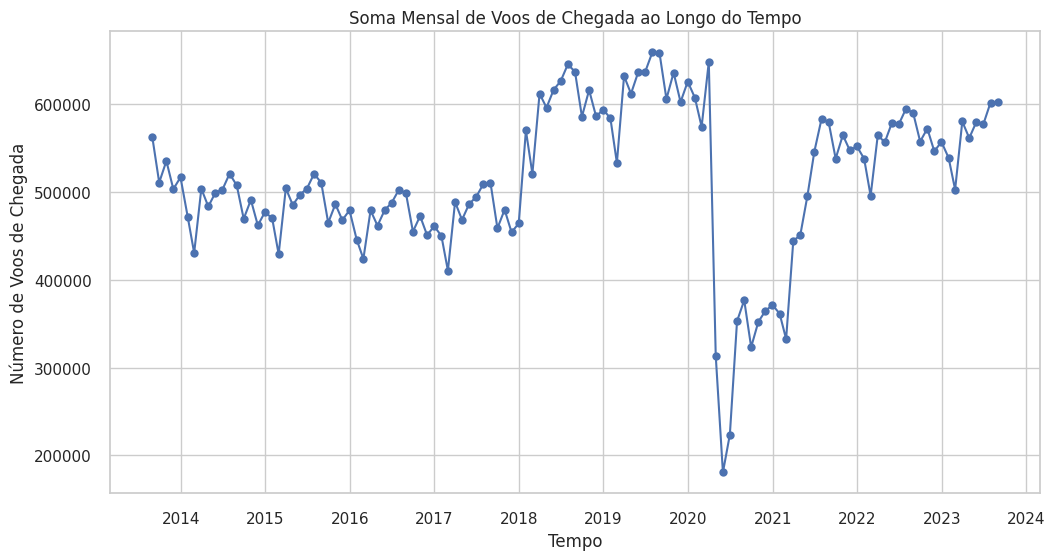

In [16]:
df_temp = df.copy()
df_temp = df_temp.set_index('date')
monthly_df = df_temp.resample('ME').sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_df['arr_flights'], marker='o', linestyle='-')
plt.title('Soma Mensal de Voos de Chegada ao Longo do Tempo')
plt.xlabel('Tempo')
plt.ylabel('Número de Voos de Chegada')
plt.show()

#### Insight Obtido

A série revela uma tendência de crescimento gradual do volume de voos até 2019, seguida por uma quebra estrutural abrupta em 2020, caracterizando um choque exógeno (pandemia). A partir de 2021 observa-se um processo de recuperação, com níveis próximos ao pré-pandemia em 2023

---


## Gráfico 12: Soma Anual de Voos de Chegada

### Objetivo

Identificar padrões de evolução anual do volume total de voos de chegada ao longo de aproximadamente uma década, permitindo identificar tendências de longo prazo, choques sistêmicos e padrões sazonais.

### Ações

* Agrupar os dados por `year`
* Somar `arr_flights` para cada ano.

### Saída

Gráfico de linhas verticais representando o volume histórico total de voos por ano.

### Insight Esperado

Evidenciar picos de alta temporada e períodos de baixa demanda, facilitando análises de capacidade e correlação com atrasos, mas agora correlacionado deretamente com os anos.

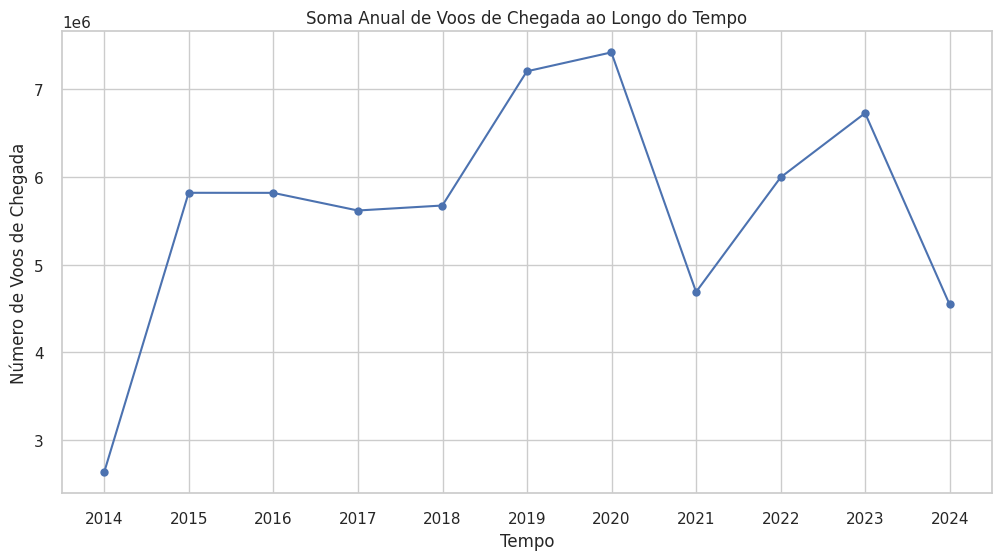

In [17]:
df_temp = df.copy()
df_temp = df_temp.set_index('date')
yearly_df = df_temp.resample('YE').sum()

plt.figure(figsize=(12, 6))
plt.plot(yearly_df['arr_flights'], marker='o', linestyle='-')
plt.title('Soma Anual de Voos de Chegada ao Longo do Tempo')
plt.xlabel('Tempo')
plt.ylabel('Número de Voos de Chegada')
plt.show()

#### Insight Obtido

Analogamente a série dos meses, esse gráfico da soma anual revela uma tendência de crescimento gradual do volume de voos até 2019, seguida por uma quebra estrutural abrupta em 2020, caracterizando um choque exógeno (pandemia). A partir de 2021 observa-se um processo de recuperação, com níveis próximos ao pré-pandemia em 2023

---


## Gráfico 13: Decomposição Sazonal

### Objetivo
Decompor a série temporal de atrasos em três componentes fundamentais — **tendência**, **sazonalidade** e **resíduo** — para separar mudanças estruturais de variações esperadas ao longo do tempo.

### Ações
- **Preparação dos dados**:
  - Agregar `arr_delay` (soma de minutos)

### Saída
Painel vertical com quatro gráficos compartilhando o eixo temporal:
- **Original**: Série temporal bruta
- **Trend (Tendência)**: Curva suavizada indicando a evolução estrutural do desempenho
- **Seasonal (Sazonalidade)**: Padrão anual recorrente (ciclo de 12 meses)
- **Resid (Resíduo)**: Ruído e eventos extraordinários não explicados pelos demais componentes

### Insight Esperado
- **Validação da recuperação**: Avaliar se a tendência indica estabilização ou deterioração da performance operacional  
- **Detecção de anomalias**: Identificar picos nos resíduos associados a eventos atípicos (ex: início da pandemia, falhas sistêmicas, greves), direcionando investigações de causa-raiz


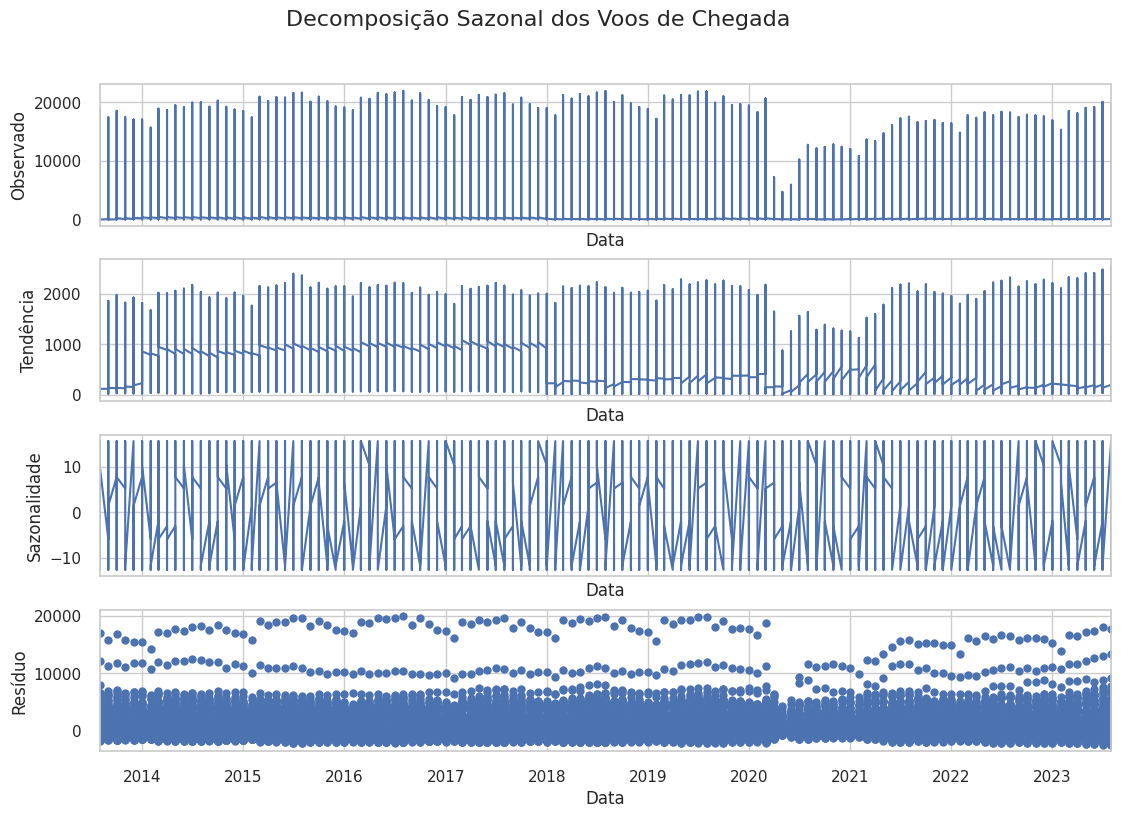

In [18]:
df_temp = df.copy()
df_temp = df_temp.set_index('date')
df_temp['arr_flights'] = df_temp['arr_flights'].fillna(df_temp['arr_flights'].median())

result = seasonal_decompose(df_temp['arr_flights'], model='additive', period=12)
fig = result.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Decomposição Sazonal dos Voos de Chegada', fontsize=16, y=1.02)

axes = fig.get_axes()
axes[0].set_ylabel('Observado')
axes[0].set_title('')
axes[1].set_ylabel('Tendência')
axes[1].set_title('')
axes[2].set_ylabel('Sazonalidade')
axes[2].set_title('')
axes[3].set_ylabel('Resíduo')
axes[3].set_title('')

for ax in axes:
    ax.set_xlabel('Data')

plt.show()

#### Insight Obtido

A decomposição confirma que a sazonalidade anual é forte e estável, enquanto a tendência captura mudanças estruturais reais no desempenho do setor, isolando o efeito da pandemia como um choque transitório nos resíduos.